In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [44]:
geohash_map = pd.read_csv(u'drive/MyDrive/Capstone/data/poi_data.csv')
geohash_vec = geohash_map[[ u'Amenity', u'Bump', u'Crossing', u'Entrance', u'Give_Way',
       u'Junction', u'Noexit', u'Railway', u'Roundabout', u'Station', u'Stop',
       u'Traffic_Calming', u'Traffic_Signal', u'Turning_Circle',
       u'Turning_Loop']]

geohash_dict={}
for index, row in geohash_map.iterrows():
    geohash_dict[row.Geohash] = np.array(geohash_vec.iloc[index])

geo_dict = dict(zip(geohash_map.Geohash.unique(), range(len(geohash_map.Geohash.unique()))))

In [47]:
import random

lookback = 8
grid_width = 5 # 栅格化粒度（每个小单元格的边长）
time_interval = 60 # 时间间隔

df = pd.read_csv(u'drive/MyDrive/Capstone/data/integrated_data_{}_{}.csv'.format(str(grid_width),str(time_interval)))

df = df [[u'TimeStep', u'predicted_accident',u'Geohash',u'geohash_code', u'DOW_cat', u'DayLight',
    u'HOD_en0', u'HOD_en1', u'HOD_en2', u'HOD_en3', u'HOD_en4', u'T-Accident',
    u'T-Congestion', u'T-Incident', u'T-Restriction', u'T-Obstruction',
    u'T-Activity', u'T-Equipment', u'T-Other', u'W-Humidity',
    u'W-Precipitation', u'W-Pressure', u'W-Temperature', u'W-Visibility',
    u'W-WindSpeed', u'W-Rain', u'W-Snow', u'W-Fog', u'W-Hail']]

print ("zero accident =",float(df[df['T-Accident']==0].shape[0])/df.shape[0])

train = df[df.TimeStep <= df.TimeStep.max()*0.8]
test = df[df.TimeStep > df.TimeStep.max()*0.8]
sampling_rate = float(train[train['T-Accident']==0].shape[0])/train.shape[0]

random.seed(996)

for t in range(0,10):

  X_train = []
  y_train = []

  for idx, frame in train.groupby(train.Geohash):

    current_frame = frame.values
    geo_vec = geohash_dict[frame.Geohash.iloc[0]]
    geo_code = geo_dict[frame.Geohash.iloc[0]]

    for i in range(lookback, current_frame.shape[0]):
        if current_frame[i, 1] > 0 :
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_train.append(a)
            y_train.append(1)
            
        elif random.uniform(0, 1) > sampling_rate:  # negative sampling for non-accident cases 
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_train.append(a)
            y_train.append(0)  
  
  X_train = np.array(X_train)
  y_train = np.array(y_train)


  X_test = []
  y_test = []

  for idx, frame in test.groupby(test.Geohash):

    current_frame = frame.values
    geo_vec = geohash_dict[frame.Geohash.iloc[0]]
    geo_code = geo_dict[frame.Geohash.iloc[0]]

    for i in range(lookback, current_frame.shape[0]):
        if current_frame[i, 1] > 0 :
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_test.append(a)
            y_test.append(1)
            
        elif random.uniform(0, 1) > sampling_rate:  # negative sampling for non-accident cases 
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_test.append(a)
            y_test.append(0)  
  
  X_test = np.array(X_test)
  y_test = np.array(y_test)


  np.save(u'drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '_time_' + str(time_interval) + '.npy',X_train) 
  print (X_train.shape)
  np.save(u'drive/MyDrive/Capstone/numpy-data/y_train_' + str(t)  + '_time_' + str(time_interval) + '.npy',y_train)
  print( y_train.shape)
  np.save(u'drive/MyDrive/Capstone/numpy-data/X_test_' + str(t) + '_time_' + str(time_interval)  + '.npy',X_test)
  print (X_test.shape)
  np.save(u'drive/MyDrive/Capstone/numpy-data/y_test_' + str(t)  + '_time_' + str(time_interval) + '.npy',y_test)
  print (y_test.shape)

zero accident = 0.9860897145446307
(6021, 216)
(6021,)
(1650, 216)
(1650,)
(6034, 216)
(6034,)
(1665, 216)
(1665,)
(6028, 216)
(6028,)
(1708, 216)
(1708,)
(6103, 216)
(6103,)
(1638, 216)
(1638,)
(6128, 216)
(6128,)
(1639, 216)
(1639,)
(6008, 216)
(6008,)
(1669, 216)
(1669,)
(6177, 216)
(6177,)
(1652, 216)
(1652,)
(5980, 216)
(5980,)
(1674, 216)
(1674,)
(5983, 216)
(5983,)
(1649, 216)
(1649,)
(6053, 216)
(6053,)
(1638, 216)
(1638,)


In [8]:
num_set = 10
n_estimator_record = np.zeros(num_set)

In [ ]:
# params = {"objective":'binary:logistic','colsample_bytree': 1.0,'subsample': 0.9, 'learning_rate': 0.08,
#                'max_depth': 10, 'alpha': 5, 'n_estimators': 500}

Train Model With Cross-Validation & 
Tune Parameter

Step 1. Tune n_estimators (To reduce the time for xgboost training, Unnecessary for Other Methods)

In [ ]:
def tun_parameters(train_x,train_y):
  xgb1 = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=10,min_child_weight=1,alpha=5,subsample=0.8,  
              colsample_bytree=0.8,objective= 'binary:logistic')  
  num = modelfit(xgb1,train_x,train_y)
  return num

def modelfit(alg,X,y,useTrainCV=True,cv_folds=5,early_stopping_rounds=50):
  if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X, label=y)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
              metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
  
  alg.fit(X,y,eval_metric='auc')
  #Predict training set:
  dtrain_predictions = alg.predict(X)
  print(dtrain_predictions.shape)
  dtrain_predprob = (dtrain_predictions >= 0.5)*1

  #Print model report:
  print ("AUC Score: %.4f" % metrics.roc_auc_score(y, dtrain_predprob))
  print ('F1-score: %.4f' % metrics.f1_score(y, dtrain_predprob))
  
  print ('n_estimators = ',cvresult.shape[0])
  print('\n\n')
  return cvresult.shape[0]


In [ ]:
for t in range(num_set):
  X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
  y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
  
  print('Numset: %d' % (t))
  print(np.average(y_train))
  n_estimator_record[t] = tun_parameters(X_train, y_train)

best_n_estimator = np.mean(n_estimator_record)
print(best_n_estimator)

Numset: 0
0.49446153846153845
(6500,)
AUC Score: 0.9609
F1-score: 0.9610
n_estimators =  46



Numset: 1
0.48200359928014397
(6668,)
AUC Score: 0.9579
F1-score: 0.9565
n_estimators =  49



Numset: 2
0.49076194838906706
(6549,)
AUC Score: 0.9628
F1-score: 0.9624
n_estimators =  44



Numset: 3
0.4906121202869791
(6551,)
AUC Score: 0.9590
F1-score: 0.9586
n_estimators =  46



Numset: 4
0.49113691931540343
(6544,)
AUC Score: 0.9510
F1-score: 0.9507
n_estimators =  37



Numset: 5
0.48986434994665445
(6561,)
AUC Score: 0.9432
F1-score: 0.9427
n_estimators =  37



Numset: 6
0.4877826680831689
(6589,)
AUC Score: 0.9562
F1-score: 0.9554
n_estimators =  44



Numset: 7
0.4918885827976737
(6534,)
AUC Score: 0.9687
F1-score: 0.9684
n_estimators =  53



Numset: 8
0.486822175098455
(6602,)
AUC Score: 0.9734
F1-score: 0.9727
n_estimators =  63



Numset: 9
0.4919638757079443
(6533,)
AUC Score: 0.9698
F1-score: 0.9695
n_estimators =  58



47.7


Step 2. Tune Other Parameters


In [ ]:
n_estimator_record = n_estimator_record.astype(np.int8)
print(n_estimator_record.dtype)

int8


1-D tuning for visulization

In [29]:
param_test = {
'max_depth':range(3,10,1),
}
auc_rec = np.zeros(num_set)
for t in range(1):
  X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
  y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
  
  print('Numset: %d' % (t))
  print(np.average(y_train))

  gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = n_estimator_record[t], max_depth=5,
                min_child_weight=5, alpha=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',nthread=8), 
              param_grid = param_test,scoring='roc_auc',n_jobs=-1, cv=5)
  gsearch1.fit(X_train,y_train)
  print(gsearch1.best_params_, gsearch1.best_score_)


Numset: 0
0.49446153846153845
{'max_depth': 3} 0.8596729031125949


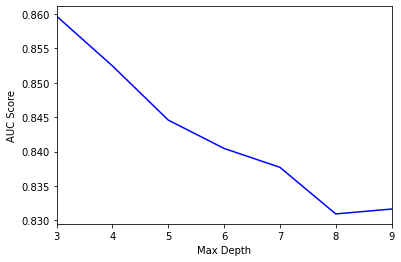

In [30]:
record = []
for mean, params in zip(gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['params']): 
  record.append(mean)
plt.plot(range(3,10), record, 'b')
plt.xlabel('Max Depth')
plt.ylabel('AUC Score')
plt.xlim(3,9)
plt.show()

In [31]:
param_test = {
'min_child_weight':range(1,6,1)
}
auc_rec = np.zeros(num_set)
for t in range(1):
  X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
  y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
  
  print('Numset: %d' % (t))
  print(np.average(y_train))

  gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = n_estimator_record[t], max_depth=3,
                min_child_weight=5, alpha=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',nthread=8), 
              param_grid = param_test,scoring='roc_auc',n_jobs=-1, cv=5)
  gsearch1.fit(X_train,y_train)
  print(gsearch1.best_params_, gsearch1.best_score_)

Numset: 0
0.49446153846153845
{'min_child_weight': 4} 0.8601832694144058


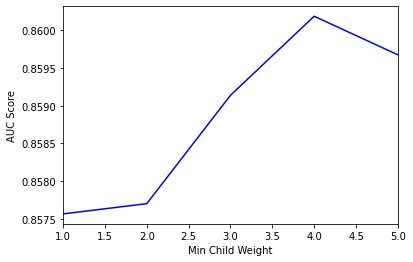

In [33]:
record = []
for mean, params in zip(gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['params']): 
  record.append(mean)
plt.plot(range(1,6), record, 'b')
plt.xlabel('Min Child Weight')
plt.ylabel('AUC Score')
plt.xlim(1,5)
plt.show()

In [ ]:
param_test = {
'max_depth':range(3,10,1),
'min_child_weight':range(1,6,1)
}

max_depth_record = np.zeros(num_set)
min_child_record = np.zeros(num_set)
for t in range(num_set):
  X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
  y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
  
  print('Numset: %d' % (t))
  print(np.average(y_train))

  gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = n_estimator_record[t], max_depth=5,
                min_child_weight=1, alpha=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',nthread=8), 
              param_grid = param_test,scoring='roc_auc',n_jobs=-1, cv=5)
  gsearch1.fit(X_train,y_train)
  #gsearch1.grid_scores_,
  print(gsearch1.best_params_, gsearch1.best_score_)
  max_depth_record[t] = gsearch1.best_params_['max_depth']
  min_child_record[t] = gsearch1.best_params_['min_child_weight']
  print('\n')
max_depth_record = max_depth_record.astype(np.int8)
min_child_record = min_child_record.astype(np.int8)

Numset: 0
0.49446153846153845
{'max_depth': 3, 'min_child_weight': 4} 0.8601832694144058



Numset: 1
0.48200359928014397
{'max_depth': 3, 'min_child_weight': 5} 0.8673598616069451



Numset: 2
0.49076194838906706
{'max_depth': 3, 'min_child_weight': 2} 0.8698449411941752



Numset: 3
0.4906121202869791
{'max_depth': 3, 'min_child_weight': 1} 0.8589539158700049



Numset: 4
0.49113691931540343
{'max_depth': 3, 'min_child_weight': 4} 0.8532869714382338



Numset: 5
0.48986434994665445
{'max_depth': 3, 'min_child_weight': 5} 0.8569028538181651



Numset: 6
0.4877826680831689
{'max_depth': 3, 'min_child_weight': 4} 0.8648830057559097



Numset: 7
0.4918885827976737
{'max_depth': 3, 'min_child_weight': 5} 0.8506668594553795



Numset: 8
0.486822175098455
{'max_depth': 3, 'min_child_weight': 4} 0.8573690954403018



Numset: 9
0.4919638757079443
{'max_depth': 4, 'min_child_weight': 5} 0.8504776506789711





Save best parameters

In [ ]:
# np.save('drive/MyDrive/Capstone/XGBoost/n_est', n_estimator_record)
# np.save('drive/MyDrive/Capstone/XGBoost/max_depth', max_depth_record)
# np.save('drive/MyDrive/Capstone/XGBoost/min_child', min_child_record)

In [28]:
n_estimator_record = np.load('drive/MyDrive/Capstone/XGBoost/n_est.npy')
max_depth_record = np.load('drive/MyDrive/Capstone/XGBoost/max_depth.npy')
min_child_record = np.load('drive/MyDrive/Capstone/XGBoost/min_child.npy')

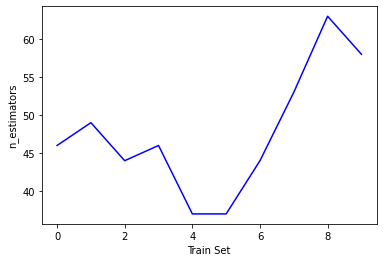

In [6]:
plt.plot(n_estimator_record, 'b')
plt.xlabel('Train Set')
plt.ylabel('n_estimators')
plt.show()

Step 3. Train the model with best parameters and save it.


In [ ]:
for t in range(num_set):
  X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
  y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
  xg_reg = XGBClassifier(learning_rate = 0.1, n_estimators = n_estimator_record[t], max_depth=max_depth_record[t],
                min_child_weight=min_child_record[t], alpha=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',nthread=8)

  xg_reg.fit(X_train,y_train)
  xg_reg.get_booster().save_model('drive/MyDrive/Capstone/XGBoost/xgb_' + str(t) + '.model')
  

AUC Score: 0.8313
F1-score: 0.8282
AUC Score: 0.8289
F1-score: 0.8213
AUC Score: 0.8363
F1-score: 0.8324
AUC Score: 0.8319
F1-score: 0.8281
AUC Score: 0.8290
F1-score: 0.8253
AUC Score: 0.8244
F1-score: 0.8160
AUC Score: 0.8321
F1-score: 0.8263
AUC Score: 0.8380
F1-score: 0.8355
AUC Score: 0.8369
F1-score: 0.8327
AUC Score: 0.8495
F1-score: 0.8472


In [10]:
for t in range(num_set):
  X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
  y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
  xg_reg = XGBClassifier(learning_rate = 0.1, n_estimators = 60, max_depth=3,
                min_child_weight=4, alpha=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',nthread=8)

  xg_reg.fit(X_train,y_train)
  xg_reg.get_booster().save_model('drive/MyDrive/Capstone/XGBoost/Xgb_' + str(t) + '.model')

Change some characteristics

In [93]:
hist_use = 8

In [20]:
for t in range(num_set):
  for k in range(hist_use):
    X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
    X_train = X_train[:,k*25:216]
    y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
    xg_reg = XGBClassifier(learning_rate = 0.1, n_estimators = 60, max_depth=3,
                  min_child_weight=4, alpha=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',nthread=8)

    xg_reg.fit(X_train,y_train)
    xg_reg.get_booster().save_model('drive/MyDrive/Capstone/XGBoost/Xgb_' + str(t) + '_hist_' + str(8-k) + '.model')

In [94]:
auc_record = np.zeros([num_set,hist_use])
auc_train_record = np.zeros([num_set,hist_use])
f1_record = np.zeros([num_set,hist_use])
f1_train_record = np.zeros([num_set,hist_use])

In [96]:
for t in range(num_set):
  for k in range(hist_use):
    X_test = np.load('drive/MyDrive/Capstone/numpy-data/X_test_' + str(t) + '.npy', allow_pickle=True)
    X_test = X_test[:,k*25:216]
    y_test = np.load('drive/MyDrive/Capstone/numpy-data/y_test_' + str(t) + '.npy', allow_pickle=True)
    pred = np.zeros(X_test.shape[0])
    for i in range(num_set):
      xgb_c = xgb.Booster(model_file='drive/MyDrive/Capstone/XGBoost/Xgb_' + str(i) + '_hist_' + str(8-k) + '.model')
      pred = pred + xgb_c.predict(xgb.DMatrix(X_test))
    pred = pred / num_set
    dtrain_predprob = (pred >= 0.5)*1

    auc_record[t,k] = metrics.roc_auc_score(y_test, pred)
    f1_record[t,k] = metrics.f1_score(y_test, dtrain_predprob)

    X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
    X_train = X_train[:,k*25:216]
    y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
    pred = np.zeros(X_train.shape[0])
    for i in range(num_set):
      xgb_c = xgb.Booster(model_file='drive/MyDrive/Capstone/XGBoost/Xgb_' + str(i) + '_hist_' + str(8-k) + '.model')
      pred = pred + xgb_c.predict(xgb.DMatrix(X_train))
    pred = pred / num_set
    dtrain_predprob = (pred >= 0.5)*1

    auc_train_record[t,k] = metrics.roc_auc_score(y_train, pred)
    f1_train_record[t,k] = metrics.f1_score(y_train, dtrain_predprob)


In [97]:
auc = auc_record.mean(axis=0)
auc_train = auc_train_record.mean(axis=0)
f1 = f1_record.mean(axis=0)
f1_train = f1_train_record.mean(axis=0)

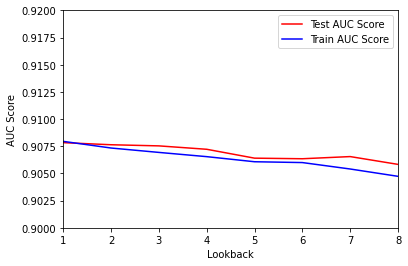

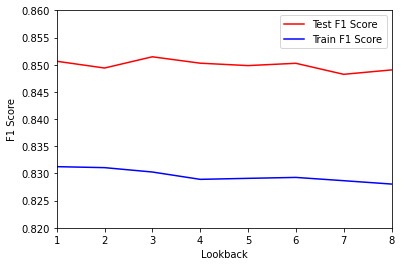

In [100]:
plt.plot(range(1,9), auc, color='red', label='Test AUC Score')
plt.plot(range(1,9), auc_train, color='blue', label='Train AUC Score')
plt.ylabel('AUC Score')
plt.xlabel('Lookback')
plt.xlim(1,8)
plt.ylim(0.9,0.92)
plt.legend()
plt.show()

plt.plot(range(1,9), f1, color='red', label='Test F1 Score')
plt.plot(range(1,9), f1_train, color='blue', label='Train F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Lookback')
plt.xlim(1,8)
plt.ylim(0.82,0.86)
plt.legend()
plt.show()

In [101]:
np.save('drive/MyDrive/Capstone/XGBoost/xgb_lookback_auc', auc)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_lookback_auc_train', auc_train)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_lookback_f1', f1)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_lookback_f1_train', f1_train)

In [102]:
np.save('drive/MyDrive/Capstone/XGBoost/xgb_lookback_auc_record', auc_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_lookback_auc_train_record', auc_train_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_lookback_f1_record', f1_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_lookback_f1_train_record', f1_train_record)
print(f1_record)

[[0.85177453 0.85101934 0.85192909 0.85044294 0.85       0.84883117
  0.84671533 0.84703434]
 [0.84603421 0.84352332 0.84707102 0.84603421 0.8447205  0.84619368
  0.84451378 0.84352332]
 [0.85177453 0.85057471 0.85148515 0.85177453 0.8513302  0.8523735
  0.84937238 0.85057471]
 [0.85355649 0.85146444 0.85370951 0.85534591 0.85400314 0.85415578
  0.85294118 0.85414481]
 [0.8491155  0.84791667 0.84927235 0.84735202 0.84735202 0.84751037
  0.84539302 0.84615385]
 [0.85266458 0.85190999 0.85504971 0.8513302  0.85221932 0.85281837
  0.85070718 0.85013055]
 [0.85044294 0.84968685 0.85148515 0.85044294 0.8491155  0.84971399
  0.84937238 0.85057471]
 [0.84297521 0.84352332 0.84444444 0.84341085 0.8447205  0.84400826
  0.84276077 0.8439606 ]
 [0.85       0.84747527 0.85059865 0.85       0.84823285 0.84839045
  0.84583333 0.84703434]
 [0.85804416 0.85684211 0.85954761 0.85669291 0.85669291 0.85864425
  0.85473684 0.85729331]]


In [103]:
time_list = [15, 30, 60]

In [58]:
for t in range(num_set):
  for k in time_list:
    X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '_time_' + str(k) + '.npy', allow_pickle=True)
    y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '_time_' + str(k) + '.npy', allow_pickle=True)
    xg_reg = XGBClassifier(learning_rate = 0.1, n_estimators = 60, max_depth=3,
                  min_child_weight=4, alpha=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',nthread=8)

    xg_reg.fit(X_train,y_train)
    xg_reg.get_booster().save_model('drive/MyDrive/Capstone/XGBoost/Xgb_' + str(t) + '_time_' + str(k) + '.model')

In [104]:
auc_record = np.zeros([num_set,3])
auc_train_record = np.zeros([num_set,3])
f1_record = np.zeros([num_set,3])
f1_train_record = np.zeros([num_set,3])

In [105]:
index = 0
for t in range(num_set):
  for k in time_list:
    X_test = np.load('drive/MyDrive/Capstone/numpy-data/X_test_' + str(t) + '_time_' + str(k)  + '.npy', allow_pickle=True)
    y_test = np.load('drive/MyDrive/Capstone/numpy-data/y_test_' + str(t) + '_time_' + str(k)  + '.npy', allow_pickle=True)
    pred = np.zeros(X_test.shape[0])
    for i in range(num_set):
      xgb_c = xgb.Booster(model_file='drive/MyDrive/Capstone/XGBoost/Xgb_' + str(i) + '_time_' + str(k) + '.model')
      pred = pred + xgb_c.predict(xgb.DMatrix(X_test))
    pred = pred / num_set
    dtrain_predprob = (pred >= 0.5)*1

    auc_record[t,index] = metrics.roc_auc_score(y_test, pred)
    f1_record[t,index] = metrics.f1_score(y_test, dtrain_predprob)

    X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '_time_' + str(k)  + '.npy', allow_pickle=True)
    y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '_time_' + str(k)  + '.npy', allow_pickle=True)
    pred = np.zeros(X_train.shape[0])
    for i in range(num_set):
      xgb_c = xgb.Booster(model_file='drive/MyDrive/Capstone/XGBoost/Xgb_' + str(i) + '_time_' + str(k) + '.model')
      pred = pred + xgb_c.predict(xgb.DMatrix(X_train))
    pred = pred / num_set
    dtrain_predprob = (pred >= 0.5)*1

    auc_train_record[t,index] = metrics.roc_auc_score(y_train, pred)
    f1_train_record[t,index] = metrics.f1_score(y_train, dtrain_predprob)
    index = index + 1
  index = 0


In [106]:
auc = auc_record.mean(axis=0)
auc_train = auc_train_record.mean(axis=0)
f1 = f1_record.mean(axis=0)
f1_train = f1_train_record.mean(axis=0)

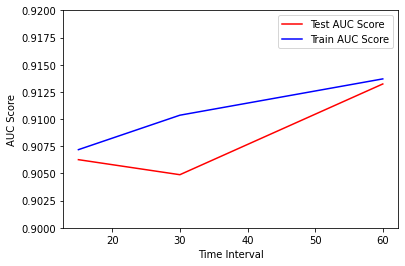

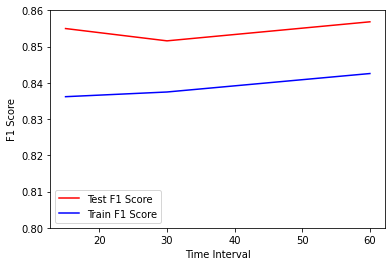

In [107]:
plt.plot(time_list, auc, color='red', label='Test AUC Score')
plt.plot(time_list, auc_train, color='blue', label='Train AUC Score')
plt.ylabel('AUC Score')
plt.xlabel('Time Interval')
plt.legend()
plt.ylim(0.9,0.92)
plt.show()

plt.plot(time_list, f1, color='red', label='Test F1 Score')
plt.plot(time_list, f1_train, color='blue', label='Train F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Time Interval')
plt.legend()
plt.ylim(0.8,0.86)
plt.show()

In [108]:
np.save('drive/MyDrive/Capstone/XGBoost/xgb_time_auc', auc)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_time_auc_train', auc_train)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_time_f1', f1)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_time_f1_train', f1_train)

In [109]:
np.save('drive/MyDrive/Capstone/XGBoost/xgb_time_auc_record', auc_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_time_auc_train_record', auc_train_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_time_f1_record', f1_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_time_f1_train_record', f1_train_record)
print(f1_record)

[[0.85506494 0.84671533 0.85541506]
 [0.86313582 0.84937238 0.86444444]
 [0.86268344 0.85115304 0.85073811]
 [0.86358867 0.85428722 0.85777288]
 [0.84627249 0.84715702 0.85919382]
 [0.85329186 0.85835095 0.85588559]
 [0.85152613 0.84145078 0.85588559]
 [0.84583762 0.85835095 0.85494505]
 [0.85953003 0.85428722 0.85635663]
 [0.84889118 0.85473684 0.85777288]]


Step 4. Evaluate the model performance on the test set

In [110]:
auc_record = np.zeros(num_set)
auc_train_record = np.zeros(num_set)
f1_record = np.zeros(num_set)
f1_train_record = np.zeros(num_set)

In [111]:
for t in range(num_set):
  X_test = np.load('drive/MyDrive/Capstone/numpy-data/X_test_' + str(t) + '.npy', allow_pickle=True)
  y_test = np.load('drive/MyDrive/Capstone/numpy-data/y_test_' + str(t) + '.npy', allow_pickle=True)
  pred = np.zeros(X_test.shape[0])
  for i in range(num_set):
    xgb_c = xgb.Booster(model_file='drive/MyDrive/Capstone/XGBoost/Xgb_' + str(i) + '.model')
    pred = pred + xgb_c.predict(xgb.DMatrix(X_test))
  pred = pred / num_set
  dtrain_predprob = (pred >= 0.5)*1

  auc_record[t] = metrics.roc_auc_score(y_test, pred)
  f1_record[t] = metrics.f1_score(y_test, dtrain_predprob)

  X_train = np.load('drive/MyDrive/Capstone/numpy-data/X_train_' + str(t) + '.npy', allow_pickle=True)
  y_train = np.load('drive/MyDrive/Capstone/numpy-data/y_train_' + str(t) + '.npy', allow_pickle=True)
  pred = np.zeros(X_train.shape[0])
  for i in range(num_set):
    xgb_c = xgb.Booster(model_file='drive/MyDrive/Capstone/XGBoost/Xgb_' + str(i) + '.model')
    pred = pred + xgb_c.predict(xgb.DMatrix(X_train))
  pred = pred / num_set
  dtrain_predprob = (pred >= 0.5)*1

  auc_train_record[t] = metrics.roc_auc_score(y_train, pred)
  f1_train_record[t] = metrics.f1_score(y_train, dtrain_predprob)

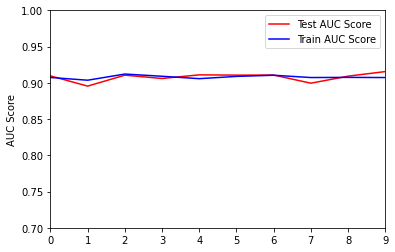

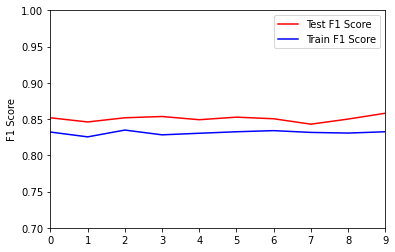

Mean AUC Score:  0.9078321177701193
Mean F1 Score:  0.850638215168272


In [112]:
plt.plot(auc_record, color='red', label='Test AUC Score')
plt.plot(auc_train_record, color='blue', label='Train AUC Score')
plt.ylabel('AUC Score')
plt.xlim(0,9)
plt.ylim(0.7,1)
plt.legend()
plt.show()

plt.plot(f1_record, color='red', label='Test F1 Score')
plt.plot(f1_train_record, color='blue', label='Train F1 Score')
plt.ylabel('F1 Score')
plt.xlim(0,9)
plt.ylim(0.7,1)
plt.legend()
plt.show()

print("Mean AUC Score: ",np.mean(auc_record))
print("Mean F1 Score: ",np.mean(f1_record))

In [92]:
np.save('drive/MyDrive/Capstone/XGBoost/xgb_auc', auc_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_auc_train', auc_train_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_f1', f1_record)
np.save('drive/MyDrive/Capstone/XGBoost/xgb_f1_train', f1_train_record)

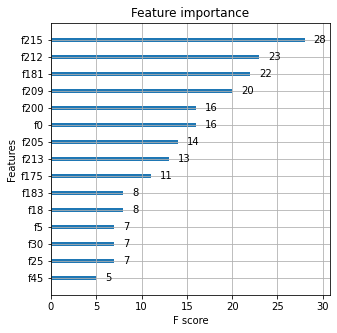

In [ ]:
xgb_c = xgb.Booster(model_file='drive/MyDrive/Capstone/XGBoost/xgb_2.model')
xgb.plot_importance(xgb_c, max_num_features=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28783 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26202 missing from current font.
  font.set_

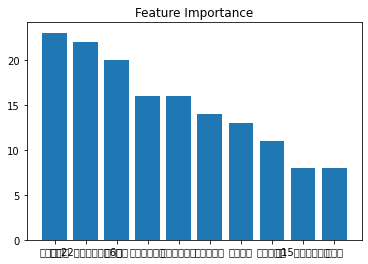

In [9]:
feature = ['信号灯个数', '晚上22点至次日早上6点', '车站个数', '颠簸区域个数', '是否为工作日', '交叉口数目', '转弯半径', '是否为白天', '前15分钟拥堵次数', '可见度']
val = [23, 22, 20, 16, 16, 14, 13, 11, 8, 8]
plt.bar(feature, val)
plt.title('Feature Importance')
plt.show()